In [39]:
import warnings
warnings.filterwarnings('ignore')

from collections import namedtuple, Counter as count
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from hyperloglog import HyperLogLog
from pyod.models.knn import KNN
from abc import abstractmethod
from nltk.util import ngrams
from pathlib import Path
from enum import IntEnum
import pandas as pd
import numpy as np
import copy
import time


np.random.seed(42)


def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        print('%r took %2.2f ms' % (method.__name__, (te - ts) * 1000))
        return result
    return timed


class Quality(IntEnum):
    GOOD = 0
    BAD = 1


class Learner:
    @abstractmethod
    def fit(history):
        pass

    @abstractmethod
    def predict(X):
        pass


class KNNLearner(Learner):
    def __init__(self):
        # https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.knn
        self.clf = None

    def fit(self, history):
        learner = KNN(contamination=.01,
                      n_neighbors=5,
                      method='mean',
                      metric='euclidean',
                      algorithm='ball_tree')
        self.clf = Pipeline([
            ('scaler', MinMaxScaler()),
            ('learner', learner)
        ]).fit(history)

        return self

    def predict(self, X):
        assert self.clf is not None, ".fit first"
        return self.clf.predict(X)


class DataProfiler:
    class __DP:
        def __init__(self):
            self.analyzer = {
                "Completeness": lambda x: self.completeness(x),
                "Uniqueness": lambda x: self.uniqueness(x),
                "ApproxCountDistinct": lambda x: self.approx_count_distinct(x),
                "Mean": lambda x: np.mean(x),
                "Minimum": lambda x: np.min(x),
                "Maximum": lambda x: np.max(x),
                "StandardDeviation": lambda x: np.std(x),
                "Sum": lambda x: np.sum(x),
                "Count": lambda x: x.shape[0],
                "FrequentRatio": lambda x: 1.*max(count(x).values())/x.shape[0],
                "PeculiarityIndex": lambda x: self.peculiarity(x),
            }

            self.dtype_checking = {
                "int64": True,
                "float64": True
            }


        def completeness(self, x):
            return 1. - np.sum(pd.isna(x)) / x.shape[0]

        def uniqueness(self, x):
            tmp = [i for i in count(x).values() if i == 1]
            return 1. * np.sum(tmp) / x.shape[0]

        def count_distinct(self, x):
            return 1. * len(count(x).keys()) / x.shape[0]

        def approx_count_distinct(self, x):
            hll = HyperLogLog(.01)
            for idx, val in x.items():
                hll.add(str(val))
            return len(hll)

        # TODO: count sketch, using deterministic count for small data
#        def count_sketch(self, matrix, sketch_size=50):
#            m, n = matrix.shape[0], 1
#            res = np.zeros([m, sketch_size])
#            hashedIndices = np.random.choice(sketch_size, replace=True)
#            print(hashedIndices)
#            randSigns = np.random.choice(2, n, replace=True) * 2 - 1 # a n-by-1{+1, -1} vector
#            matrix = matrix * randSigns
#            for i in range(sketch_size):
#                res[:, i] = np.sum(matrix[:, hashedIndices == i], 1)
#            return res

        def peculiarity(self, x):
            def _peculiarity_index(word, count2grams, count3grams):
                t = []
                for xyz in ngrams(str(word), 3):
                    xy, yz = xyz[:2], xyz[1:]
                    cxy, cyz = count2grams.get(xy, 0), count2grams.get(yz, 0)
                    cxyz = count3grams.get(xyz, 0)
                    t.append(.5* (np.log(cxy) + np.log(cyz) - np.log(cxyz)))
                return np.sqrt(np.mean(np.array(t)**2))

            aggregated_string = " ".join(map(str, x))
            c2gr = count(ngrams(aggregated_string, 2))
            c3gr = count(ngrams(aggregated_string, 3))
            return x.apply(lambda y: _peculiarity_index(y, c2gr, c3gr)).max()

    instance = None

    def __init__(self):
        if not DataProfiler.instance:
            DataProfiler.instance = DataProfiler.__DP()

    def __getattr__(self, name):
        return getattr(self.instance, name)

    def _compute_for_column(self, column, *analyzers):
        return [self.instance.analyzer[name](column) for name in analyzers]

    # @timeit
    def compute_for(self, batch, return_labels=False):
        profile, labels = [], []
        generic_metrics = ["Completeness", "Uniqueness",
                       "ApproxCountDistinct", "FrequentRatio"]
        numeric_metrics = ["Mean", "Minimum", "Maximum",
                       "StandardDeviation", "Sum"]

        for col, dtype in zip(batch.columns, batch.dtypes):
        # For every column, compute generic metrics,
        # add additional numeric metrics for numeric columns
            metrics = copy.deepcopy(generic_metrics)
            if self.dtype_checking.get(dtype.name, False):
                metrics.extend(numeric_metrics)
            if dtype == 'object':  # Check for string-like columns
                metrics.append("PeculiarityIndex")
        # We assume the data schema to be stable, column order unchanged,
        # no additional validation for feature order happens, optional
            column_profile = self._compute_for_column(batch[col], *metrics)
            profile.extend(column_profile)
            labels.extend([f'{col}_{m}' for m in metrics])
        return profile if not return_labels else (profile, labels)


    def compute_completenness(self, batch, return_labels=False):
        profile, labels = [], []
        for col in batch.columns:
            # Only compute completeness for each column
            completeness_value = self.instance.analyzer["Completeness"](batch[col])
            profile.append(completeness_value)
            labels.append(f'{col}_Completeness')

        return profile if not return_labels else (profile, labels)
    
class DataQualityValidatior:
    def __init__(self):
        self.clf = KNNLearner()
        self.history = []

    def add(self, batch):
        self.history.append(batch)
        return self

    def test(self, batch):
        # print(len(self.history))
        # re-fit the model from scratch
        self.clf.fit(self.history)

        decision = self.clf.predict([batch])
        return Quality.GOOD if int(decision) == 0 else Quality.BAD


Batch = namedtuple('Batch', 'id clean dirty')

def get_batch_fnames():
    folder = Path('/../partitions/')
    batches = []
    for day in range(1, 54):
        fclean = folder / f'/../clean/FBPosts_clean_{day}.tsv'
        fdirty = folder / f'/../dirty/FBPosts_dirty_{day}.tsv'
        assert fclean.exists()
        assert fdirty.exists()
        batches.append(Batch(day, fclean, fdirty))
    return iter(batches)


def good_or_bad(batch):
    return np.random.choice([Quality.GOOD, Quality.BAD], p=[9./10, 1./10])



## Completeness selon scalabilité

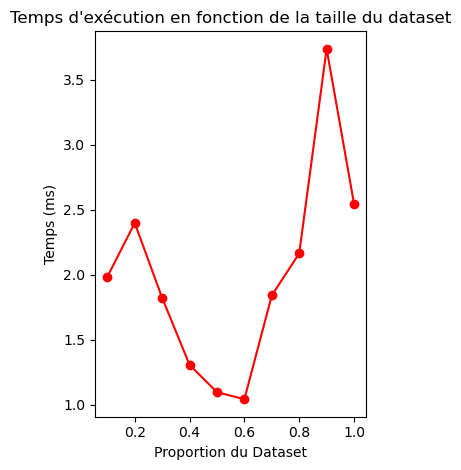

In [50]:
import matplotlib.pyplot as plt
import time


def read_dataset(filepath):
    return pd.read_csv(filepath)

def compute_completeness_and_time(data, column_name, proportions):
    completeness_scores = []
    times = []
    for proportion in proportions:
        start_time = time.time()
        batch_size = int(proportion * len(data))
        batch = data.iloc[:batch_size]
        completeness = DataProfiler().compute_completenness(batch[[column_name]])
        end_time = time.time()
        completeness_scores.append(completeness[0])
        times.append((end_time - start_time)*1000) 
    return completeness_scores, times

# Chemin vers le dataset
dataset_path = 'kc_house_data.csv'
house_data = read_dataset(dataset_path)

# Proportions du dataset à analyser
proportions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Calcul de la complétude et du temps d'exécution
completeness_scores, times = compute_completeness_and_time(house_data, 'id', proportions)

# Création du graphique
plt.figure()


plt.subplot(1, 2, 2)
plt.plot(proportions, times, marker='o', color='red')
plt.title('Temps d\'exécution en fonction de la taille du dataset')
plt.xlabel('Proportion du Dataset')
plt.ylabel('Temps (ms)')

plt.tight_layout()
plt.show()


## Uniqueness selon scalabilité

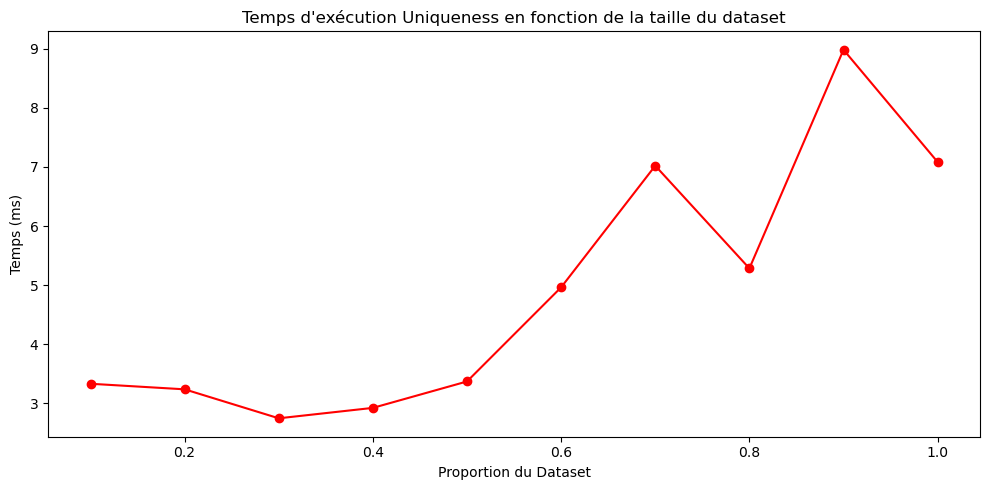

In [29]:
def compute_uniqueness(batch, return_labels=False):
    uniqueness_scores, labels = [], []
    for col in batch.columns:
        # Calculer l'unicité pour chaque colonne
        uniqueness_value = DataProfiler().uniqueness(batch[col])
        uniqueness_scores.append(uniqueness_value)
        labels.append(f'{col}_Uniqueness')

    return uniqueness_scores if not return_labels else (uniqueness_scores, labels)


def compute_uniqueness_and_time(data, column_name, proportions):
    uniqueness_scores = []
    times = []
    for proportion in proportions:
        start_time = time.time()
        batch_size = int(proportion * len(data))
        batch = data.iloc[:batch_size]
        uniqueness = compute_uniqueness(batch[[column_name]])
        end_time = time.time()
        uniqueness_scores.append(uniqueness[0])
        times.append((end_time - start_time)*1000)  # Temps en secondes
    return uniqueness_scores, times


uniqueness_scores, times = compute_uniqueness_and_time(house_data, 'price', proportions)

# Création du graphique
plt.figure(figsize=(10, 5))

plt.plot(proportions, times, marker='o', color='red')
plt.title('Temps d\'exécution Uniqueness en fonction de la taille du dataset')
plt.xlabel('Proportion du Dataset')
plt.ylabel('Temps (ms)')

plt.tight_layout()
plt.show()

## Consistency

In [33]:
house_data['date'] = pd.to_datetime(house_data['date'])

In [35]:
# Modified functions to return proportions

def proportion_positive_price(house_data):
    return (house_data['price'] > 0).mean()

def proportion_non_negative_bedrooms_bathrooms_floors(house_data):
    return house_data[['bedrooms', 'bathrooms', 'floors']].applymap(lambda x: x >= 0).all(axis=1).mean()

def proportion_correct_sqft_living(house_data):
    return (house_data['sqft_living'] == house_data['sqft_above'] + house_data['sqft_basement']).mean()

def proportion_correct_yr_built(house_data):
    return (house_data['yr_built'] <= house_data['date'].dt.year).mean()

# Apply the modified functions
prop_positive_price = proportion_positive_price(house_data)
prop_non_negative_bed_bath_floors = proportion_non_negative_bedrooms_bathrooms_floors(house_data)
prop_correct_sqft_living = proportion_correct_sqft_living(house_data)
prop_correct_yr_built = proportion_correct_yr_built(house_data)

prop_positive_price, prop_non_negative_bed_bath_floors, prop_correct_sqft_living, prop_correct_yr_built



(1.0, 1.0, 1.0, 0.9994447786054689)

## Demo ADQ sur House Sales King County

**** Potential problem with a batch!
Good
Good
**** Potential problem with a batch!
Good
Good
Good
Good
Good
**** Potential problem with a batch!
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
**** Potential problem with a batch!
Good
**** Potential problem with a batch!
**** Potential problem with a batch!
Good
Good
**** Potential problem with a batch!
Good
Good
Good
Good
**** Potential problem with a batch!
Good
Good
Good
Good
**** Potential problem with a batch!
**** Potential problem with a batch!
Good
Good
**** Potential problem with a batch!
Good
Good
Good
Good
Good
Good
Good
Good
Good
**** Potential problem with a batch!
Good
**** Potential problem with a batch!
Good
Good
Good
Good
Good
Good
Good
Good
**** Potential problem with a batch!
Good
Good
**** Potential problem with a batch!
Good
Good
Good
Good
Good
Good
Good
**** Potential problem with a batch!
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
**** Potential problem with a batch!
Good
Good
Good
Good
**** Potent

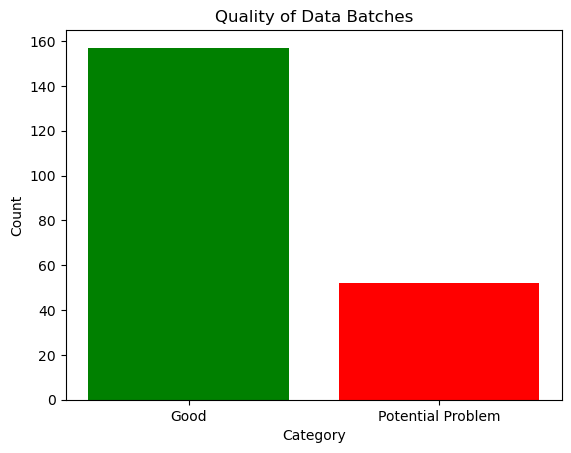

In [54]:
import matplotlib.pyplot as plt

def get_house_sales_batches(file_path, batch_size):
    # Assurez-vous que la taille de chaque batch est adaptée à la taille de votre dataset
    data = pd.read_csv('kc_house_data.csv')
    for start in range(0, len(data), batch_size):
        yield data[start:start + batch_size]


def demo_house_sales(file_path, batch_size=100):
    dqv = DataQualityValidatior()
    batches = get_house_sales_batches(file_path, batch_size)

    good_count = 0
    problem_count = 0

    # Phase d'entraînement initiale
    for _ in range(8):
        batch_data = next(batches)
        profile = DataProfiler().compute_for(batch_data)
        dqv.add(profile)

    # Phase de test
    for batch_data in batches:
        profile = DataProfiler().compute_for(batch_data)
        res = dqv.test(profile)

        if res == Quality.GOOD:
            dqv.add(profile)
            good_count += 1
            print('Good')
        else:
            # Gérez les lots de données problématiques
            problem_count += 1
            print(f'**** Potential problem with a batch!')

    # Affichage du diagramme en barres
    categories = ['Good', 'Potential Problem']
    values = [good_count, problem_count]
    colors = ['green', 'red']  # Vert pour 'Good', Rouge pour 'Potential Problem'

    plt.bar(categories, values, color=colors)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title('Quality of Data Batches')
    plt.show()

if __name__ == "__main__":
    file_path = 'kc_house_data.csv'
    demo_house_sales(file_path)

